# Introduction

Version 1.3 20210712

In this assignment we will use distributional semantics to investigate how some words in the English language changed over the course of the last two centuries. To do so, we will use two sections from the **Corpus of Historical American English (COHA)** - one with texts written between 1800 and 1840, and a contemporary one with texts written between 2000 and 2010. 

In distributional semantics, we use the context of a word to represent its meaning. In the first part of this assignment we will use simple bi-gram statistics to get a first feel for how words' co-occurrences can reflect their meaning, then move to two more refined sampling methods called **Continuous Bag of Words (CBOW)** and **SkipGram** which frequently used in developing distributional semantics models, and finally train a full **Word2Vec model** on the two corpora and investigate how certain words have developed over time by comparing their representations.

You can download the COHA data for this assignment from here:

https://drive.google.com/drive/folders/13Kzo666XmYLQv8VMjR8Xc_P6f0-mrlY_?usp=sharing

**DISCLAIMER**: You are given permission to use the COHA data only for this assignment. You are not allowed to use the data for other projects, and you are not allowed to distribute it in any form. 

---

FURTHER READING:

*    Distributional Semantics and Linguistic Theory. Boleda, 2020


# Q1 Word Co-occurrence Vectors (15 marks)

To start off, we will calculate word co-occurrence statistics from a sample of the two portions of the COHA texts, and build word vectors based on the co-occurrence counts.

---

FURTHER READING:
*   The Corpus of Historical American English: 400 million words, 1810-2009. Davies, 2010 
*   CCOHA: Clean Corpus of Historical American English. Alatrash et. al, 2020


## Q1.1 Pre-processing (5 marks)

First, complete the pre-processing function so that it returns a cleaned version as a list of sentences. Consider how different pre-processing steps will affect the co-occurrence statistics and report why you decide to include or exclude specific pre-processing steps.


In [2]:
import nltk
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amaan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import time
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
def load_sentences(file):
    """
    Reads a COHA sample file and pre-processes it into a list of strings.
    """
    sentences = []
    with open(file) as f:
        for line in f:
            sentences.append(line)          
    return sentences

In [5]:
import string
import re
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

def preprocessing(corpus):
    """
    Takes a collection of sentences and returns a cleaned version. 
    
    Complete this function by applying techniques like tokenisation, 
    non-word filtering, stop-word removal and stemming to clean the input.
    
    :return : a list of strings containing cleaned sentences
    :rtype : list(str)
    """
    clean_text = []
    # TODO: Pre-process corpus and add cleaned sentences to clean_text
    for sent in corpus:
        my_punctuation = punctuation.replace("'", "")
        # remove all punctuation except apostrophes
        sentence = sent.translate(str.maketrans("", "", my_punctuation))
        
        # make all words lower case
        sentence2 = sentence.lower() #([word.lower() for word in sentence])
        
        # remove \n representing new lines
        sentence2 = sentence2.strip('\n')
        
        # remove double whitespaces created from removing the \n's
        sentence2 = re.sub(' +', ' ', sentence2)
        
        # remove stopwords
        stop_words = stopwords.words('english')
        stopwords_dict = Counter(stop_words)
        sentence2 = ' '.join([word for word in sentence2.split() if word not in stopwords_dict])

        clean_text.append(sentence2)
        
    return clean_text

In [6]:
# punctuation removal for reference

# from string import punctuation
# type(punctuation)

# my_punctuation = punctuation.replace("'", "")
# my_punctuation
# '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
# "It's right, isn't it?".translate(str.maketrans("", "", my_punctuation))


In [7]:
test = load_sentences('2000_sample.txt')

In [8]:
test

['The Revenge of Randal Reese-Rat Chapter One Elizabeth Mad-Rat loved warm , tropical places , but the midday African sun was more than she could take .\n',
 'It might have been bearable if she could have stopped to rest in the shade of one of the strange-looking African trees along the roadside , but she had no time to spare .\n',
 'The ship shed come on , the SS Ratterdam , was leaving early the next morning to sail back to New York , and she was determined that she and her daughter should be on it .\n',
 'The sun was so powerful that Elizabeth finally lifted her traveling case up over her head as a parasol .\n',
 'Shed found the suitcase , a French cigarette box with a dancing gypsy on it , years ago on the island of Martinique .\n',
 'It wasnt heavy  --  there was nothing in it but her comb and a seashell shed picked up on a strip of beach on her way out of Dakar that morning  --  but her arms soon grew tired anyway .\n',
 'Im not as young a rat [UNK] finally stopped in the shade o

In [9]:
test2 = preprocessing(test)

In [10]:
test2

['revenge randal reeserat chapter one elizabeth madrat loved warm tropical places midday african sun could take',
 'might bearable could stopped rest shade one strangelooking african trees along roadside time spare',
 'ship shed come ss ratterdam leaving early next morning sail back new york determined daughter',
 'sun powerful elizabeth finally lifted traveling case head parasol',
 'shed found suitcase french cigarette box dancing gypsy years ago island martinique',
 'wasnt heavy nothing comb seashell shed picked strip beach way dakar morning arms soon grew tired anyway',
 'im young rat unk finally stopped shade palm tree collapsed traveling case',
 'caught breath realized parched seeing thick vine twisted around tree trunk like spiral staircase started search coconut',
 'last year jamaica shed sipped lovely milk broken coconut',
 'reached top tree wasnt coconut seen',
 'worse even way couldnt make hill daughter lived',
 'terrible muttered realizing must taken wrong turn way dakar',
 

- Since the following analysis will be based on the co-occurrence of words, it is not really necessary to include punctuation.
- The words have all been converted to lower case, so that a word at the beginning of the sentence is considered synonymous to the same word elsewhere in the sentence.
- All "\n" symbols for signifying a new line have been removed, as we obviously don't want these being considered as words by any subsequent functions.
- All double whitespaces, resulting from the above, have been removed, otherwise these blank spaces will be considered as words by later functions.
- All English stopwords have been removed, as they present a noise factor (not particularly relevant) when using later functions that identify co-occurence of words.

## Q1.2 Extracting co-occurrence counts (5 marks)

Building a word co-occurrence matrix directly can cause memory usage problems: the target/context word matrix can have of the order of 100,000 rows and columns (the size of the observed vocabulary). One way to get round this is to use sparse matrices, which are memory- and computation-efficient - but they can be a bit complicated to work with if you're not used to them. Here, we will take a different approach: we'll use the existing CountVectorizer class to do the work for us (it uses sparse matrix libraries underneath). This means doing something slightly different from the standard approach described in lectures: instead of basing our co-occurrence counts on a sliding fixed-width window, we will be basing them on co-occurrence of words within the same sentence.

In this step, utilise the CountVectorizer class to transform the input text into a square, symmetric matrix with a zero diagonal, in which the entries are co-occurrence counts. See the comments below for more detail on how to achieve this.

For more information on the CountVectorizer, refer to https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [12]:
import numpy as np

def create_coo_matrix(data, vectorizer):
    """
    Uses the specified vectorizer to create bi-gram co-occurence statistics 
    for the data.

    Complete this function by applying the vectorizer to the corpus data to 
    create a co-occurrence matrix. Then transform the matrix into a symmetric 
    one by transposing and multiplying it, and set the diagonal to zero. 

    :return : a square matrix indicating bi-gram co-occurrence statistics
    :rtype : pd.DataFrame
    """
    start = time.time()

    # TODO: Apply CountVectorizer to data, resulting in a word/sentence matrix
    word_sent_mat = vectorizer.fit_transform(data)

    # TODO: Transpose matrix and multiply original by transpose, resulting in a word/word matrix
    word_word_mat = word_sent_mat.transpose()*word_sent_mat

    # TODO: Set diagonal to zero
    n = word_word_mat.shape[0]
    word_word_mat[range(n), range(n)] = 0

    # Extract the matrix' word index from the vectorizer
    word_index = vectorizer.get_feature_names() 
    # Create an easy-to-read version of the matrix with pandas
    coo_df = pd.DataFrame(data = word_word_mat.toarray(), columns = word_index, index = word_index)

    end = time.time()    
    print("Building the co-occurrence matrix took {} seconds.".format(end - start)) 
    return coo_df

In [13]:
# Initialise the CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words = 'english', min_df = 5)

In [14]:
# can ignore
# #word_sent_mat_test = vectorizer.fit_transform(sample_1800)
# word_sent_mat_test.shape
# #len(vectorizer.get_feature_names())

In [15]:
# can ignore
# # #word_word_mat_t = np.matmul(word_sent_mat_test, word_sent_mat_test.transpose())
# word_word_mat_test = word_sent_mat_test.transpose()*word_sent_mat_test
# # #word_sent_mat_test.transpose()
# word_word_mat_test

In [16]:
# Load the sample of the 1800-1840 section of COHA
sample_1800=load_sentences("1800_sample.txt")
print("The sample contains {} sentences.".format(len(sample_1800)))

# Pre-process the data and establish a bi-gram co-occurence matrix with the CountVectorizer
sample_1800_clean = preprocessing(sample_1800)
coo_df_1800 = create_coo_matrix(sample_1800_clean, vectorizer)

The sample contains 50000 sentences.
Building the co-occurrence matrix took 2.641740560531616 seconds.


In [17]:
# Print the first sentence in the 1800-1840 section
sample_1800_clean[0]

'true principle conservatism'

In [18]:
# Load the sample of the 2000-2010 section of COHA
sample_2000=load_sentences("2000_sample.txt")
print("The sample contains {} sentences.".format(len(sample_2000)))

# Pre-process the data and establish a bi-gram co-occurence matrix with the CountVectorizer
sample_2000_clean = preprocessing(sample_2000)
coo_df_2000 = create_coo_matrix(sample_2000_clean, vectorizer)

The sample contains 50000 sentences.
Building the co-occurrence matrix took 3.1472156047821045 seconds.


In [19]:
# Print the first sentence in the 2000-2010 section
sample_2000_clean[0]

'revenge randal reeserat chapter one elizabeth madrat loved warm tropical places midday african sun could take'

## Q1.3 Corpus Analysis (5 marks)

Now that we have simple co-occurrence statistics, we cstart investigating how words were used in the two different periods - and how this changed between the two periods in our data. 

We can do this in two ways: (a) examine the co-occurrence counts directly to analyse pairwise co-occurrence, and (b) use the rows of our co-occurrence matrix as word vectors, and examine the similarity between them.

First, for method (a), extract the 15 words that co-occur most often with the word 'war' in the two co-occurrence matrices and report any iteresting findings. 

Next, for method (b), use cosine similarity to determine the similarity of the co-occurrence vectors of the words 'fight' and 'sword' first in the 1800-1840 section, and then in the 2000-2010 portion. Report what you observe.


In [20]:
# TODO: Determine the 15 words that co-occur most often with 'war' in the 1800-1840 section
coo_df_1800.nlargest(15, 'war').index

Index(['unk', '1kb', 'footnote', 'great', 'said', 'like', 'thy', 'life',
       'close', 'men', 'old', 'arms', 'certain', 'far', 'state'],
      dtype='object')

In [21]:
# TODO: Determine the 15 words that co-occur most often with 'war' in the 2000-2010 section
coo_df_2000.nlargest(15, 'war').index

Index(['world', 'unk', 'ii', 'intelligence', 'new', 'civil', 'cold', 'end',
       'people', 'time', 'american', 'years', 'medal', 'said', 'days'],
      dtype='object')

Interesting to see that 'unk' comes up in both the 1800s and the 2000s co-occurrence matrices. It's possible that it's an abbreviation for "unknown", relating to death tolls. "Said" also comes up for both, maybe due to quotes from military personell.

'ii' is identified for the 2000-2010 corpus which presumably is in reference to World War 'II'. 'civil' and 'cold are also obvious references to different wars.

In [22]:
# TODO: Determine the cosine similarity between the words 'fight' and 'sword' in the 1800-1840 section
import sklearn as sk
from sklearn import metrics

sk.metrics.pairwise.cosine_similarity(coo_df_1800.loc[['fight']], coo_df_1800.loc[['sword']], dense_output=False)

array([[0.60910227]])

In [23]:
# TODO: Determine the cosine similarity between the words 'fight' and 'sword' in the 2000-2010 section
sk.metrics.pairwise.cosine_similarity(coo_df_2000.loc[['fight']], coo_df_2000.loc[['sword']], dense_output=False)

array([[0.14839785]])

It seems that the words "sword" and "fight" appear in a much greater degree of similar contexts in the 1800s samples as compared to the 2000s samples. This is possibly due to a greater prevalence of sword fighting in 1800s as compared to 2000s.

In [ ]:
# OPTIONAL: Explore other words or word pairs that might be interesting to compare

# Q2 Understanding Word2Vec Training (10 marks)

Co-occurrence count vectors are a bit limited in how well they model word meaning and change, and it's more usual to use more advanced word-vectorization methods like Word2Vec. Word2Vec can use two different methods to specify or sample a target word's context: the Continuous Bag of Words (CBOW) and SkipGram models. In this part, you'll be tasked to implement these two approaches to understand how they sample and represent word co-occurrence in context.



## Q2.1 Continuous Bag of Words (CBOW) (5 marks)

The first method is CBOW (Continuous Bag Of Words):


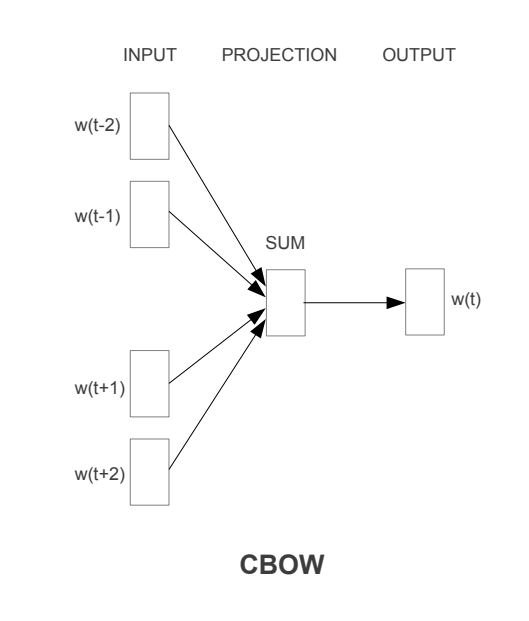

With CBOW, we use the left and right context of a target word to try to predict the target. To create training data for CBOW, we therefore have to create sliding context windows that collect a given number of previous and following words as context, and link those contexts to the targets. For this assignment, we'll use a window size of 2, so we'll look at the two words before and the two words after a word in the corpus and consider that to be its context. You do not need to add padding, but should skip words that don't have enough words to the left or to the right to fill the full context window.

As an example, processing the sentence "The quick brown fox jumped over the lazy dog" should yield the following output:

```
[(['The', 'quick', 'fox', 'jumped'], 'brown'),
 (['quick', 'brown', 'jumped', 'over'], 'fox'),
 (['brown', 'fox', 'over', 'the'], 'jumped'),
 (['fox', 'jumped', 'the', 'lazy'], 'over'),
 (['jumped', 'over', 'lazy', 'dog'], 'the')]
```
The first part of each tuple is the context, which in our case is 4 words (2 left and 2 right), and the second entry is the target (which should go in the middle of the context). 

---

FURTHER READING: 
*   Exploiting Similarities among Languages for Machine Translation. Mikolov et al. 2013

In [24]:
def create_cbow_dataset(data, window_size):
    """
    Creates a dataset of CBOW contexts for a given corpus. The context size is 
    determined by window_size to the right and to the left of the target. 

    Complete this function by processing the data and adding words with their 
    corresponding contexts to the cbow_data list. You do not need to add padding,
    but should skip words that don't have enough words to the left or to the 
    right to fill the full context window. Make sure that the output is a single 
    list of target-context pairs, and that they are not separated by sentence.

    See the sample output in the next field as reference

    :return : a leist of tuples representing a context and it's target
    :rtype : [(str, [str])]
    """
    cbow_data = []    
    # TODO: Process the data into target-context tuples using the specified window size
    for sent in data:
        
        #split sentence into separate tokens
        tokens = sent.split(" ")
         
        for i, t in enumerate(tokens):
            
            # ignore tokens for which there is no token at the index after deducting the window size 
            if i>=window_size:
                
                # tokens for which there is no index after adding the window size are ignored
                try:
                    # previous context tokens up to window size are extracted
                    cont = [tokens[i-j] for j in range(window_size,0,-1)]
                    
                    # post context tokens up to window size are extracted
                    cont2 =[tokens[i+k] for k in range(1,window_size+1)]
                    
                    # context words are concatenated to the same list
                    cont.extend(cont2)
                    
                    # target token extracted
                    targ = tokens[i]
                    
                    # context word list and target are appended to array
                    cbow_data.append((cont,targ))
                except:
                    pass
    
                
    return cbow_data

In [25]:
# CBOW Sample
create_cbow_dataset(["The quick brown fox jumped over the lazy dog"], 2)

[(['The', 'quick', 'fox', 'jumped'], 'brown'),
 (['quick', 'brown', 'jumped', 'over'], 'fox'),
 (['brown', 'fox', 'over', 'the'], 'jumped'),
 (['fox', 'jumped', 'the', 'lazy'], 'over'),
 (['jumped', 'over', 'lazy', 'dog'], 'the')]

Output should be:

```
[(['The', 'quick', 'fox', 'jumped'], 'brown'),
 (['quick', 'brown', 'jumped', 'over'], 'fox'),
 (['brown', 'fox', 'over', 'the'], 'jumped'),
 (['fox', 'jumped', 'the', 'lazy'], 'over'),
 (['jumped', 'over', 'lazy', 'dog'], 'the')]
```



## Q2.2: Skip-Gram (5 marks)

The second method is the Skip-Gram model:

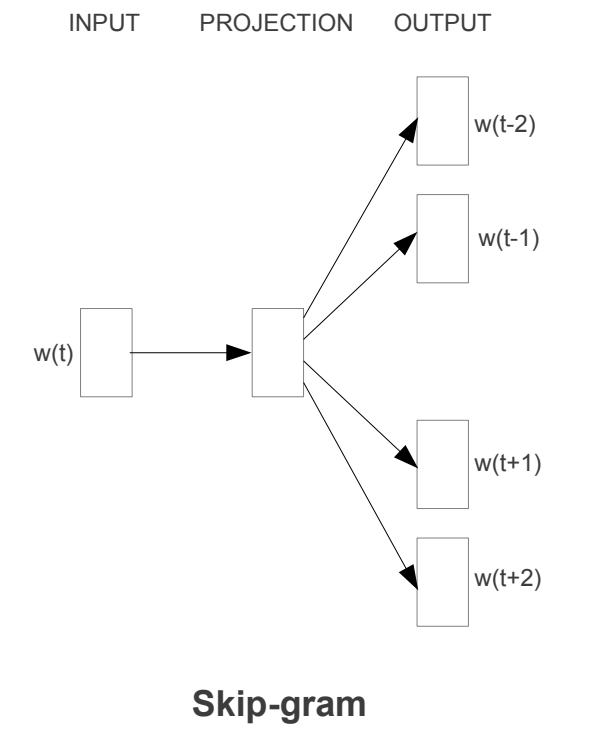

With SkipGrams, we go the other way round: given a word, we want to predict its context. However, this is quite heavy on training, so we simplify the task a little: Given two words, determine whether they are neighbours (whithin the range of the window size) in the corpus. For this assignment, we'll again use a window size of 2, so we'll look at the two words before and the two words after a word in the corpus and consider that to be its context. You do not need to add padding, but should skip words that don't have enough words to the left or to the right to fill the full context window.

Instead of adding the full context as training instance, in this case we create triplets containing the target, one of its context words, and a binary indicator to show that they are neighbours. So processing the sentence "The quick brown fox jumped over the lazy dog" should yield samples like

```
[('brown', 'The', 1),
 ('brown', 'quick', 1),
 ('brown', 'fox', 1),
 ('brown', 'jumped', 1),
 ('fox', 'quick', 1),
 ('fox', 'brown', 1),
 ...]
```
Besides adding these positive samples, we can further speed up training by adding negative samples. To create negative samples, we simply pick a number of random words from the corpus and asssign them a negative binary flag, e.g.

```
('brown', 'timer', 0)
```
For this assignment, we'll add the same number of negative samples as positive ones for each target, so there should be a total of 8 entries for each target word in the corpus. To make the negative samples more helpful, we also only want to use random words that appear at least 10 times in the corpus. You can again use the CountVectorizer to build this vocabulary.


In [26]:
import random

In [27]:
def create_skipgram_dataset(data, window_size):
    """
    Creates a SkipGram dataset for a given corpus. The context size is 
    determined by window_size to the right and to the left of the target. 

    Complete this function establishing a vocabulary from the corpus, where 
    each word should appear at least 10 times. You can use the CountVectorizer 
    for this, too.
    Then process sentences like your did for CBOW, but adding training samples
    as triplets (target, context_word, flag). 
    Finally, add the same number of negative samples for each target word by 
    selecting random words from the vocabulary and adding them as negative 
    instances.

    :return : a list of triplets representing a target, a context word, and a 
              binary flag indicating whether they are neighbours
    :rtype : [(str, str, bool)]
    """
    skip_data = []

    # TODO: Build a vocabulary with a minimum occurrence threshold of 10
    dict = []
    
    for i, row in enumerate(coo_df_1800.values):
        if row.sum() >= 10:
            dict.append(coo_df_1800.iloc[i].index[i])
    

    # TODO: Add positive samples for a target and its context words
    for sent in data:
        
        #split sentence into separate tokens
        tokens = sent.split(" ")
         
        for i, t in enumerate(tokens):
            
            # ignore tokens for which there is no token at the index after deducting the window size 
            if i>=window_size:
                
                # tokens for which there is no index after adding the window size are ignored
                try:
                    # previous context tokens up to window size are extracted, and joined to a tuple containing the target word and a binary value of 1
                    cont = [(tokens[i], tokens[i-j], 1) for j in range(window_size,0,-1)]
                    
                    # post context tokens up to window size are extracted, and joined to a tuple containing the target word and a binary value of 1
                    cont2 =[(tokens[i], tokens[i+k], 1) for k in range(1,window_size+1)]
                    
                    # context + target word tuples concatenated to the same list
                    cont.extend(cont2)
                    
                    # TODO: Add the same number of negative samples for each target.
                    rand = random.choices(dict, k=window_size*2)
                    neg = [(tokens[i], r, 0) for r in rand]
                    cont.extend(neg)
                    
                    # context word list and target are appended to array
                    skip_data.append(cont)
                    
                except:
                    pass
    
    

     
    # To implement the negative sampling, pick random words from the 
    # vocabulary you created. 
   
    return skip_data

In [30]:
create_skipgram_dataset(sample_1800_clean, 2)[:8]

[[('conservatism', 'rather', 1),
  ('conservatism', 'principle', 1),
  ('conservatism', 'true', 1),
  ('conservatism', 'society', 1),
  ('conservatism', 'fortune', 0),
  ('conservatism', 'essence', 0),
  ('conservatism', 'histories', 0),
  ('conservatism', 'dismount', 0)],
 [('true', 'principle', 1),
  ('true', 'conservatism', 1),
  ('true', 'society', 1),
  ('true', 'society', 1),
  ('true', 'magazine', 0),
  ('true', 'bosom', 0),
  ('true', 'end', 0),
  ('true', 'independent', 0)],
 [('society', 'conservatism', 1),
  ('society', 'true', 1),
  ('society', 'society', 1),
  ('society', 'end', 1),
  ('society', 'rostrum', 0),
  ('society', 'retreats', 0),
  ('society', 'tending', 0),
  ('society', 'affect', 0)],
 [('society', 'true', 1),
  ('society', 'society', 1),
  ('society', 'end', 1),
  ('society', 'welfare', 1),
  ('society', 'counsel', 0),
  ('society', 'sitting', 0),
  ('society', 'announced', 0),
  ('society', 'models', 0)],
 [('end', 'society', 1),
  ('end', 'society', 1),
  (

Output should be similar to

```
[('conservatism', 'rather', 1),
 ('conservatism', 'principle', 1),
 ('conservatism', 'true', 1),
 ('conservatism', 'society', 1),
 ('conservatism', 'parts', 0),
 ('conservatism', 'struggling', 0),
 ('conservatism', 'smiling', 0),
 ('conservatism', 'intent', 0)]
```



# Q3 Word2Vec (15 marks)

Now that we know how to create the training data for distributional semantics tools, we'll use a pre-implemented version of Word2Vec (which usually uses SkipGram training) to speed things up a little. Word2Vec is still one of the most-used approaches to create static word embeddings - and we'll use it to learn word embeddings for the two different periods of the COHA data to get a better idea of how word meaning has changed over time. 

This time we provide you with the full code, and your job lies in investigating the results. 


## Q3.1 Building Word2Vec embeddings (5 marks)

We'll start with word embeddings (i.e. word vectors) of size 50 - which means that the full co-occurrence matrix is compressed into a lower dimensionality - but dimensions carry more information than they do in the sparse matrix, and double the window size to 4. Depending on your machine, **training the models might take between 5 and 10 minutes each**. 

Use the code given here to train two models, one for each of the time period corpora.

Again, check the 15 most similar words to 'war' in both corpora, and determine the cosine similarity between the word pairs 'fight' and 'sword' in the two different corpora. Report what you find.

---

FURTHER READING: 
*    Distributed Representations of Words and Phrases and their Compositionality. Mikolov et al., 2013
*    Diachronic Word Embeddings Reveal Statistical Laws of Semantic Change. Hamilton et al., 2016
*    Word embeddings quantify 100 years of gender and ethnic stereotypes. Garg et al., 2018
*    Analysing Lexical Semantic Change with Contextualised Word Representations. Giulianelli et al., 2020

In [34]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in c:\users\amaan\anaconda3\lib\site-packages (4.0.1)


In [35]:
import gensim
from gensim.models import Word2Vec

C:\Users\amaan\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [36]:
assert gensim.__version__ == '4.0.1', "Please run '!pip install --upgrade gensim' to udpate gensim to version 4.0.1"

In [37]:
def load_period(file):
    start = time.time()
    sentences = []
    with open(file) as f:
        for line in f:
            sentences.extend([word_tokenize(s) for s in sent_tokenize(line)])
    end = time.time()
    
    print("Processing took {} seconds.".format(end - start))
    print("The period contains {} sentences.".format(len(sentences)))
            
    return sentences

In [38]:
start = time.time()

model_1800 = Word2Vec(sentences=load_period("1800.txt"), vector_size=50, window=2, min_count=1, workers=4)
model_1800.save("1800_word2vec.model")

end = time.time()
print("Training the model took {} seconds.".format(end - start))

Processing took 172.46526384353638 seconds.
The period contains 965249 sentences.
Training the model took 242.61211037635803 seconds.


In [39]:
# Uncomment this line if you want to load a pre-trained model instead of training it again.
# model_1800 = Word2Vec.load("COHA/1800_word2vec.model")

In [40]:
start = time.time()

model_2000 = Word2Vec(sentences=load_period("2000_half.txt"), vector_size=50, window=2, min_count=1, workers=4)
model_2000.save("2000_word2vec.model")

end = time.time()
print("Training the model took {} seconds.".format(end - start))

Processing took 139.7542588710785 seconds.
The period contains 950389 sentences.
Training the model took 190.81406331062317 seconds.


In [41]:
# Uncomment this line if you want to load a pre-trained model instead of training it again.
# model_2000 = Word2Vec.load("COHA/2000_word2vec.model")

In [42]:
# TODO: Determine the 15 words that are most similar to 'war' in the 1800-1840 section
vector = model_1800.wv['war']  # get numpy vector of a word
sims = model_1800.wv.most_similar('war', topn=15)  # get other similar words
sims

[('contest', 0.7649850845336914),
 ('struggle', 0.7529557347297668),
 ('wars', 0.7257969975471497),
 ('rebellion', 0.7215275764465332),
 ('conflict', 0.7123152017593384),
 ('revolution', 0.6987873911857605),
 ('battle', 0.6841161251068115),
 ('conspiracy', 0.6823939681053162),
 ('warfare', 0.6597253680229187),
 ('strife', 0.653421938419342),
 ('trial', 0.6460051536560059),
 ('confederation', 0.6456925868988037),
 ('negotiation', 0.6424112915992737),
 ('slavery', 0.6356677412986755),
 ('insurrection', 0.6344214081764221)]

Using the gensim Word2Vec model seems to find a larger amount of words that are typically more associated with the target word, 'war', (such as 'warfare', 'rebellion', 'conflict' etc.) as compared to the co-occurrence vector method - although there is much more data being used in this model so that is likely the main cause. It also provides a normalised magnitude of the similarity which is a useful statistic.

In [43]:
# TODO: Determine the 15 words that are most similar to 'war' in the 2000-2010 section
vector = model_2000.wv['war']  # get numpy vector of a word
sims = model_2000.wv.most_similar('war', topn=15)  # get other similar words
sims

[('battle', 0.8347118496894836),
 ('Iraq', 0.7722570300102234),
 ('dispute', 0.7549460530281067),
 ('race', 0.7540993690490723),
 ('conflict', 0.7529914975166321),
 ('government', 0.7414141297340393),
 ('crisis', 0.7407495975494385),
 ('debate', 0.7313151359558105),
 ('slavery', 0.7276627421379089),
 ('court', 0.7267854809761047),
 ('state', 0.7203249335289001),
 ('disaster', 0.7159275412559509),
 ('struggle', 0.7118920087814331),
 ('operation', 0.7106739282608032),
 ('subject', 0.705210268497467)]

Again for the 2000s data, using the gensim Word2Vec model seems to find a greater proportion of words that are typically more associated with the target word, 'war', (such as 'conflict', 'battle', 'crisis' etc.) as compared to the co-occurrence vector method - but again we are using much more data in this model. The word "Iraq" is also included which is more relevant to war in 2000s as compared to 1800s

In [44]:
# TODO: Determine the cosine similarity between the words 'fight' and 'sword' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('fight','sword')
cos_dist_1800

0.6503051817417145

In [45]:
# TODO: Determine the cosine similarity between the words 'fight' and 'sword' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('fight','sword')
cos_dist_2000

0.6670309901237488

It's interesting to see that the cosine similarity for 'fight' and 'sword' for the 1800.txt data in this model is very similar to that seen for the sample data when using the co-occurrence vector matrix. For the 2000_half.txt data used in this model however, the score has jumped from ~0.15 to ~0.67 which is a significant difference. It seems that the larger corpus contains many more examples of 'fight' and 'sword' appearing in the same context for the Word2Vec model.

## Q3.2 Examining meaning change over time (10 marks)

Pick three additional words that you think might have changed their meaning over time, and investigate them using the two models. Note that you **can't directly compare individual embeddings (vectors) between the two different models**, as they are randomly initialised and therefore vectors will not correspond to one another. However, you can always compare pairwise similarities, i.e. the distances between word pairs in the two different corpora.

For example, for each of your three words, you could choose two words that are likely to be similar in meaning in the different time periods, and check whether the similarities change as you expect. But don't feel limited by this suggestion - feel free to investigate the similarities however you like.


In [ ]:
# TODO: Choose three words that you expect to change in meaning between the two periods. 
# Investigate the behaviour of their vectors with respect to other words in the two spaces, and explain what you find.

**word**: virtual  //  **comparison words**: simulate, nearly

Traditional meaning is, almost or nearly as described. In current times it can also mean, not physically existing as such but made by software to appear to do so.


**word**: apothecary  //  **comparison words**: pharmacy, surgery

Older meaning for apothecary referred to a pharmacist or a pharmacy. Modern day meaning is generally a medical professional who formulates and dispenses medicine to physicians, surgeons, and patients. Although similar, this subtle change in meaning could produce differing results.


**word**:babe  //  **comparison words**: partner, infant

Classic meaning is that of a young child. In modern day times, it can be used as a term of endearment for a partner.

In [50]:
# TODO: Determine the 15 words that are most similar to 'virtual' in the 1800-1840 section
vector = model_1800.wv['virtual']  # get numpy vector of a word
sims = model_1800.wv.most_similar('virtual', topn=15)  # get other similar words
sims

[('overthrowing', 0.8486905694007874),
 ('governmental', 0.8436212539672852),
 ('provisional', 0.8334713578224182),
 ('protective', 0.8301280736923218),
 ('constructive', 0.8273079991340637),
 ('suspending', 0.8205932974815369),
 ('compensative', 0.8142948746681213),
 ('non-importation', 0.8141130805015564),
 ('pre-existing', 0.8100075125694275),
 ('abolishing', 0.8009093403816223),
 ('levying', 0.7962192296981812),
 ('retarding', 0.7929508686065674),
 ('stricter', 0.7881864905357361),
 ('mediatorial', 0.7872898578643799),
 ('authorizing', 0.7868707776069641)]

In [51]:
# TODO: Determine the 15 words that are most similar to 'virtual' in the 2000-2010 section
vector = model_2000.wv['virtual']  # get numpy vector of a word
sims = model_2000.wv.most_similar('virtual', topn=15)  # get other similar words
sims

[('high-tech', 0.8158502578735352),
 ('traditional', 0.8124050498008728),
 ('communal', 0.7960413694381714),
 ('high-end', 0.7922111749649048),
 ('storage', 0.7797247171401978),
 ('tactical', 0.7777676582336426),
 ('sacred', 0.7758752703666687),
 ('residential', 0.7750372290611267),
 ('commercial', 0.7694645524024963),
 ('private', 0.768159031867981),
 ('mining', 0.7664740681648254),
 ('surgical', 0.7630365490913391),
 ('modern', 0.7557241916656494),
 ('permanent', 0.75281822681427),
 ('neural', 0.7504780888557434)]

For the 1800-1840 section, the Word2Vec model identified somewhat unexpected similar words to 'virtual' based on the classic definition. For the 2000-2010 period however, it did pick up on some more modern contexts, such as 'high-tech' (with the highest score of 0.816) and 'neural'. 

In [56]:
# TODO: Determine the cosine similarity between the words 'virtual' and 'reality' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('virtual','simulate')
cos_dist_1800

0.6062401235103607

In [57]:
# TODO: Determine the cosine similarity between the words 'virtual' and 'reality' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('virtual','simulate')
cos_dist_2000

0.5207397043704987

In [54]:
# TODO: Determine the cosine similarity between the words 'virtual' and 'nearly' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('virtual','nearly')
cos_dist_1800

1.0010942071676254

In [55]:
# TODO: Determine the cosine similarity between the words 'virtual' and 'nearly' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('virtual','nearly')
cos_dist_2000

0.807902991771698

It's strange to see that 'simulate' has a higher cosine simlarity to 'virtual' in the 1800s, as you might expect it to be more relevant to virtual reality in the 2000s than other contexts. This may be due to the fact that the text is from early 2000s rather than the proceeding decade where developments had progressed further.

As expected, the cosine similarity of 'nearly' and 'virtual' are relatively high for both periods but even higher for 1800s, as it was probably used in that context more frequently in the 1800s.

In [58]:
# TODO: Determine the 15 words that are most similar to 'apothecary' in the 1800-1840 section
vector = model_1800.wv['apothecary']  # get numpy vector of a word
sims = model_1800.wv.most_similar('apothecary', topn=15)  # get other similar words
sims

[('overseer', 0.9041704535484314),
 ('Outlaw', 0.8969888687133789),
 ('inspector', 0.8774085640907288),
 ('aiddecamp', 0.8717749118804932),
 ('inquest', 0.8713366389274597),
 ('emissary', 0.8703470230102539),
 ('ass', 0.8689919710159302),
 ('umpire', 0.8663755655288696),
 ('elector', 0.8662183880805969),
 ('Album', 0.8630922436714172),
 ('alderman', 0.8630089163780212),
 ('accountant', 0.8615427613258362),
 ('enchanter', 0.8602879643440247),
 ('alligator', 0.8594369888305664),
 ('adder', 0.8575835824012756)]

In [59]:
# TODO: Determine the 15 words that are most similar to 'apothecary' in the 2000-2010 section
vector = model_2000.wv['apothecary']  # get numpy vector of a word
sims = model_2000.wv.most_similar('apothecary', topn=15)  # get other similar words
sims

[('80yard', 0.9174517393112183),
 ('aster', 0.915291965007782),
 ('incubator', 0.9099804759025574),
 ('eyesore', 0.9078658223152161),
 ('anteater', 0.9069784879684448),
 ('alias', 0.9068654179573059),
 ('understatement', 0.9062330722808838),
 ('enigma', 0.9059649705886841),
 ('eyelash', 0.9058470129966736),
 ('incantation', 0.9047704935073853),
 ('MFA', 0.9041396975517273),
 ('individualist', 0.9022716283798218),
 ('anvil', 0.9018722772598267),
 ('artiste', 0.9014875292778015),
 ('erection', 0.9008908271789551)]

From the 1800-1840 section, we can see the algorithm has picked up some similar words that are relevant to the classic definition, such as 'inquest' and 'enchanter'. For the 2000-2010 section it has piscked up on some words that are more associated with the classic definition (such as 'enchanter') and some that are more associated with a modern definition (such as 'incubator').

In [62]:
# TODO: Determine the cosine similarity between the words 'apothecary' and 'pharmacy' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('apothecary','pharmacy')
cos_dist_1800

0.49881988763809204

In [61]:
# TODO: Determine the cosine similarity between the words 'apothecary' and 'pharmacy' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('apothecary','pharmacy')
cos_dist_2000

0.4959862232208252

In [67]:
# TODO: Determine the cosine similarity between the words 'apothecary' and 'surgery' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('apothecary','surgery')
cos_dist_1800

0.552919328212738

In [68]:
# TODO: Determine the cosine similarity between the words 'apothecary' and 'surgery' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('apothecary','surgery')
cos_dist_2000

0.8682791888713837

We can see that the cosine similarities for 'apothecary' and 'pharmacy' are very similar for both periods, with reasonable strength.

For 'apothecary' and 'surgery' however, the cosine similarity is much greater for the 2000s, showing the generally changed meaning in modern contexts.

In [69]:
# TODO: Determine the 15 words that are most similar to 'babe' in the 1800-1840 section
vector = model_1800.wv['babe']  # get numpy vector of a word
sims = model_1800.wv.most_similar('babe', topn=15)  # get other similar words
sims

[('bride', 0.8720414042472839),
 ('maid', 0.8548899292945862),
 ('nurse', 0.8147324919700623),
 ('child', 0.8126737475395203),
 ('dove', 0.8074154853820801),
 ('widow', 0.803885817527771),
 ('sire', 0.7965378761291504),
 ('baby', 0.7924363017082214),
 ('boy', 0.7867566347122192),
 ('harp', 0.7865206003189087),
 ('bower', 0.7839052081108093),
 ('bridegroom', 0.767474353313446),
 ('sister', 0.7653787136077881),
 ('minstrel', 0.7607682347297668),
 ('pillow', 0.7595323324203491)]

In [70]:
# TODO: Determine the 15 words that are most similar to 'babe' in the 2000-2010 section
vector = model_2000.wv['babe']  # get numpy vector of a word
sims = model_2000.wv.most_similar('babe', topn=15)  # get other similar words
sims

[('dude', 0.8912172317504883),
 ('sweetie', 0.8621510863304138),
 ('hon', 0.8315714001655579),
 ('mister', 0.8300955295562744),
 ('anyhow', 0.8187223672866821),
 ('mehn', 0.8012657761573792),
 ('sweetheart', 0.7881562113761902),
 ('bammo', 0.7831714153289795),
 ('Nap', 0.7806836366653442),
 ('bro', 0.7804605960845947),
 ('pussycat', 0.7798203229904175),
 ('motherfucker', 0.7789286375045776),
 ('mothahfuckah', 0.7785323858261108),
 ('eh', 0.7735236287117004),
 ('Pinky', 0.7704412341117859)]

For 1800-1840 period, the algorithm has picked up on some similar words which are relevant to the classic meaning, such as 'baby' and 'child' with strong scores. For the 2000-2010 period, we see words that are more associated with modern 'term of endearment'type meaning, such as 'sweetie' and 'hon' in the top 3 highest scoring words.

In [71]:
# TODO: Determine the cosine similarity between the words 'babe' and 'partner' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('babe','partner')
cos_dist_1800

0.3380032181739807

In [72]:
# TODO: Determine the cosine similarity between the words 'babe' and 'partner' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('babe','partner')
cos_dist_2000

0.673913836479187

In [79]:
# TODO: Determine the cosine similarity between the words 'babe' and 'infant' in the 1800-1840 section
cos_dist_1800 = model_1800.wv.distance('babe','infant')
cos_dist_1800

0.3892017602920532

In [80]:
# TODO: Determine the cosine similarity between the words 'babe' and 'infant' in the 2000-2010 section
cos_dist_2000 = model_2000.wv.distance('babe','infant')
cos_dist_2000

0.7210110425949097

It's unsurprising to see that the cosine similarity between 'babe' and 'partner' in the 2000s is roughly double that of the 1800s. It is strange/interesting however to see that the cosine similarity of 'babe' and 'infant' is so much greater in the 2000s than the 1800s, especially as 'baby' was the 8th highest scoring similar word identified by the previous algorithm.

In [66]:
# can ignore

# for finding words to use

# for i in coo_df_2000.index:
#     print(i)

01
03
05
10
100
1000
10000
100000
101st
106
10th
11
110
1130
12
120
1200
1215
125
13
135
14
140
14yearold
15
150
1500
15000
16
17
18
180
18th
19
1906
1917
1918
1919
1920s
1926
1929
1931
1944
1945
1948
1949
1950
1950s
1952
1953
1954
1957
1958
1959
1960
1960s
1965
1968
1969
1970
1970s
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1980s
1981
1982
1983
1984
19841991
1985
1986
1987
1988
1989
1990
1990s
1991
1992
1993
1994
1995
1996
1997
1998
1999
1st
20
200
2000
20000
200000
2001
2002
2003
2004
2005
2006
2007
2008
2009
20s
20th
21
21st
22
23
230
23rd
24
240
25
250
2500
25000
250000
26
27
28
29
2d
30
300
3000
301
31
32
33
330
34
35
350
36
360networks
37
38
39
40
400
4000
40000
41
42
43
44
45
450
45000
46
47
48
49
4th
50
500
5000
50000
500000
506th
52
53
54
55
56
57
58
5g
5point
60
600
60s
61
62
63
630
64
65
66
67
68
69
70
71
72
73
730
74
75
76
77
78
79
80
800
81
82
83
84
85
86
87
88
90
900
90s
91
911
92
93
94
95
96
98
99
aari
aaron
aba
abandon
abandoned
abandonment
abc
abdomen
abilities


couric
course
courses
court
courtesy
courthouse
courting
courtney
courts
courtship
courtyard
cousin
cousins
couture
cover
coverage
covered
covering
covers
coveted
cow
coward
cowboy
cowboys
coworkers
cows
cox
cozy
cp
cpa
cpap
crack
cracked
cracker
cracking
cracks
cradle
cradled
craft
crafted
crafts
cramped
cramps
crank
cranky
crap
crash
crashing
crater
craved
craving
crawford
crawl
crawled
crawling
crayons
crazy
crc
cream
creamy
create
created
creates
creating
creation
creative
creator
creature
creatures
credential
credentials
credibility
credit
creditors
credits
creed
creek
creeping
creole
crept
crescent
crew
crews
crib
cried
cries
crime
crimes
criminal
criminals
crisis
crisp
cristina
criteria
critic
critical
criticism
critics
croatia
croats
crooked
crop
crops
cross
crossed
crosses
crossing
crosslegged
crouched
crow
crowd
crowded
crowds
crown
crowned
crucial
crude
cruel
cruise
crumbled
crumbling
crumbs
crumpled
crunch
crush
crushed
crusoe
crust
cruz
crying
crystal
cub
cuba
cuban
cube
c

instructor
instrument
instruments
insufficient
insult
insurance
intact
intake
integrated
integration
integrity
intellectual
intelligence
intelligent
intend
intended
intending
intense
intensely
intensity
intent
intention
intentions
intently
interact
interaction
interactions
interactive
intercourse
interested
interesting
interests
interfere
interior
intermittent
intern
internal
internally
international
internet
interrupted
intersection
interstate
intervention
interventions
interview
interviewed
interviews
intimate
intimidated
intramural
intricate
intrigued
intriguing
introduce
introduced
introduction
intubation
intuition
invaded
invading
invaluable
invariably
invasion
invent
invented
inventory
invest
invested
investigate
investigated
investigation
investigations
investigator
investigators
investing
investment
investments
investor
investors
invisible
invitation
invitations
invite
invited
inviting
involve
involved
involvement
involves
involving
inward
iowa
ipo
iran
iraq
iraqi
iraqis
irelan

restricted
result
resulted
resulting
results
resume
resumed
resurrected
retail
retain
retained
retention
retire
retired
retirement
retreat
retreated
retreating
retribution
retrieved
retrospect
return
returned
returning
returns
rev
reveal
revealed
revealing
reveals
revelation
revenge
revenue
revenues
reverend
reverse
reversed
review
reviewed
reviews
revival
revived
revolution
revolutionary
reward
rewarded
rewards
reynolds
rfbs
rhetorical
rhine
rhode
rhymes
rhythm
rib
ribbon
ribbons
ribs
rica
rican
ricard
rice
rich
richard
richards
riches
richest
rico
rid
ride
rider
rides
ridge
ridiculous
riding
rifle
riflemen
rifles
right
rights
rigid
rigorous
rikers
rim
ring
ringed
ringing
rings
rinsed
rip
ripe
ripped
rise
risen
rises
rising
risk
risked
risks
risky
ritual
rival
rivals
river
rivers
road
roads
roadside
roar
roared
roaring
roarke
roast
roasted
rob
robbery
robe
robert
roberts
robes
robinson
robots
robust
rochester
rochilieu
rock
rocked
rocket
rockies
rocking
rocks
rocky
rod
rode
rodia
roe
